In [1]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sbn

print(os.listdir("/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset"))

['test.csv', '.~lock.sample_submission.csv#', 'sample_submission.csv', 'train.csv', 'GCP-Coupons-Instructions.rtf']


In [2]:
#read train and test dataset 
TRAIN_PATH = "/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset/train.csv"
TEST_PATH = "/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset/test.csv"
with open(TRAIN_PATH) as file:
    len_train = len(file.readlines())

print(len_train)

55423857


In [3]:
#train_temp = pd.read_csv(TRAIN_PATH, nrows=5)
#print("training dataset head:")
#print(train_temp)
#test_temp = pd.read_csv(TEST_PATH, nrows=5)
#print("test dataset head:")
#print(test_temp)

training dataset head:
                             key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2     

In [5]:
#chunksize = 1000

train_types = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

test_types =  {'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

train_cols = list(train_types.keys())
test_cols = list(test_types.keys())

def clean_df(PATH, cols, datatypes, chunksize):
    if PATH == TEST_PATH:
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')

            df_list.append(chunk)
            #print(len(df_list))
        return pd.concat(df_list)
    
    elif(PATH == TRAIN_PATH):
        X_df_list = []
        y_df_list = []
        #df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):  
            #converting pickup datetime to proper format
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            #outlier removal
            #remove rows with passenger count 0 and more than 6
            chunk = chunk[(chunk['passenger_count'] > 0) & (chunk['passenger_count'] < 7) ]
            
            #remove rows with fare amount less than $2 and greater than $400 
            chunk = chunk[(chunk['fare_amount'] > 2.0) & (chunk['fare_amount'] < 400.0)]     
            
            # Remove data with invalid coordinates
            # NY Coordinates are around 40 N and 74 W
            # 1 degree is equal to around 69 miles
            # So this range should be fine for our purpose
            chunk = chunk[(chunk['pickup_latitude'] < 42.0) & (chunk['pickup_latitude'] > 39.0)]
            chunk = chunk[(chunk['dropoff_latitude'] < 42.0) & (chunk['dropoff_latitude'] > 39.0)]
            chunk = chunk[(chunk['pickup_longitude'] < -70.0) & (chunk['pickup_longitude'] > -75.0)]
            chunk = chunk[(chunk['dropoff_longitude'] < -70.0) & (chunk['dropoff_longitude'] > -75.0)]
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)
            
            chunk = chunk[(chunk['haversine_distnace'] > 0.1) & (chunk['haversine_distnace'] < 100)] 
            
            #appending chunks to the dataframe list
            #df_list.append(chunk)
            y_df_list.append(chunk['fare_amount'])
            chunk.drop(labels = 'fare_amount', axis=1, inplace=True)
            X_df_list.append(chunk)
            
        #df = pd.concat(df_list)
        X_df = pd.concat(X_df_list)
        y_df = pd.concat(y_df_list)
        return  X_df, y_df

def add_datetime_features(data_chunk):
    data_chunk['hour'] = data_chunk.pickup_datetime.dt.hour
    data_chunk['day'] = data_chunk.pickup_datetime.dt.day
    data_chunk['month'] = data_chunk.pickup_datetime.dt.month
    data_chunk['weekday'] = data_chunk.pickup_datetime.dt.weekday
    data_chunk['year'] = data_chunk.pickup_datetime.dt.year
    
    return data_chunk
    
def add_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180.0
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...    

#insample dataset
train_target, train_label = clean_df(TRAIN_PATH, train_cols, train_types, chunksize = 500000)
#n_train = len(train_label)
print(train_target.shape)

#out of samples dataset
#test_dataset = clean_df(TEST_PATH, test_cols, test_types, chunksize = 2000)
#n_test = len(test_dataset)
#print(n_test)

(53121848, 12)


In [6]:
train_target.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace
count,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07,5.312185e+07
mean,-4.042616e+01,2.021281e+01,-4.042616e+01,2.021281e+01,1.692245e+00,1.351786e+01,1.571534e+01,6.268106e+00,3.041219e+00,2.011745e+03,2.120659e+00
std,2.548512e+01,1.284154e+01,2.548512e+01,1.283654e+01,1.307554e+00,6.515235e+00,8.684614e+00,3.436147e+00,1.948923e+00,1.865785e+00,2.558867e+00
min,-1.184380e+03,-2.478886e+03,-1.184340e+03,-7.435461e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,2.009000e+03,1.000002e-01
25%,-7.399229e+01,4.073658e+01,-7.399158e+01,4.073558e+01,1.000000e+00,9.000000e+00,8.000000e+00,3.000000e+00,1.000000e+00,2.010000e+03,8.049665e-01
50%,-7.398212e+01,4.075338e+01,-7.398063e+01,4.075388e+01,1.000000e+00,1.400000e+01,1.600000e+01,6.000000e+00,3.000000e+00,2.012000e+03,1.363254e+00
75%,-7.396848e+01,4.076755e+01,-7.396555e+01,4.076840e+01,2.000000e+00,1.900000e+01,2.300000e+01,9.000000e+00,5.000000e+00,2.013000e+03,2.464364e+00
max,4.090051e+01,6.511403e+02,4.115649e+01,6.511375e+02,6.000000e+00,2.300000e+01,3.100000e+01,1.200000e+01,6.000000e+00,2.015000e+03,9.997092e+01


In [ ]:
#drop location features as the distance has already been calculated and added to the dataset
features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude']
train_target.drop(labels = features_to_drop, axis=1, inplace=True)
print(train_target.shape)

Text(0.5, 1.0, 'Histogram ride distances in miles')

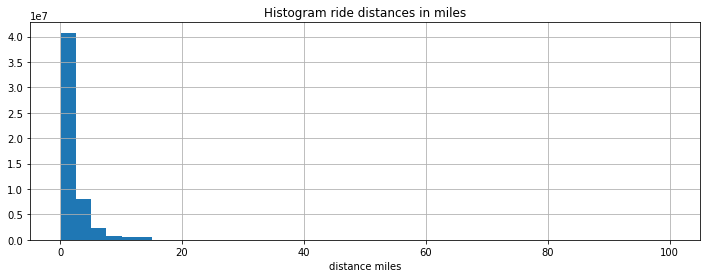

In [7]:
#histogram of haversine distance 
train_target[train_target.haversine_distnace<100].haversine_distnace.hist(bins=40, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')

In [ ]:
train_df = pd.concat([train_target, train_label], axis = 1)
print(train_df.shape)

corrs = train_df.corr()
plt.figure(figsize = (12, 12))
sbn.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);


(53121848, 13)
